In [1]:
import os
import tarfile
import urllib.request

data_dir = "stanford_dogs"
os.makedirs(data_dir, exist_ok=True)

url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
filename = os.path.join(data_dir, "images.tar")

if not os.path.exists(filename):
    print("Téléchargement en cours...")
    urllib.request.urlretrieve(url, filename)
    print("Téléchargement terminé.")
else:
    print("Fichier déjà téléchargé.")

if not os.path.exists(os.path.join(data_dir, "Images")):
    print("Extraction en cours...")
    with tarfile.open(filename, "r") as tar:
        tar.extractall(path=data_dir)
    print("Extraction terminée.")
else:
    print("Dossier déjà extrait.")

extract_path = os.path.join(data_dir, "Images")

classes = sorted(os.listdir(extract_path))
print(f"{len(classes)} classes de chiens trouvées :")
print(classes[:5], "...")

Fichier déjà téléchargé.
Dossier déjà extrait.
120 classes de chiens trouvées :
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu'] ...


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2025-08-07 08:17:35.130644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 08:17:35.144253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754554655.159788    8476 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754554655.164740    8476 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754554655.176471    8476 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
data_dir = "stanford_dogs/Images"


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [4]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(120, activation='softmax')
])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-07 08:17:38.445639: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
print(train_generator.class_indices)
print(train_generator.num_classes)


{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

In [6]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=32
)


model.save("model_chien.h5")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 1574s 3s/step - accuracy: 0.0096 - loss: 4.8749 - val_accuracy: 0.0111 - val_loss: 4.7887
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 1514s 3s/step - accuracy: 0.0117 - loss: 4.7899 - val_accuracy: 0.0123 - val_loss: 4.7867
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 1203s 2s/step - accuracy: 0.0115 - loss: 4.7874 - val_accuracy: 0.0118 - val_loss: 4.7868
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 1121s 2s/step - accuracy: 0.0122 - loss: 4.7888 - val_accuracy: 0.0115 - val_loss: 4.7882
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 1549s 3s/step - accuracy: 0.0120 - loss: 4.7863 - val_accuracy: 0.0123 - val_loss: 4.7855
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 2233s 4s/step - accuracy: 0.0120 - loss: 4.7864 - val_accuracy: 0.0123 - val_loss: 4.7851
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 2308s 4s/step - accuracy: 0.0120 - loss: 4.7902 - val_accuracy: 0.0123 - val_loss: 4.7846
Epoch 8/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 2228s 4s/step - accuracy: 0.0122 - loss: 4.7850 - 

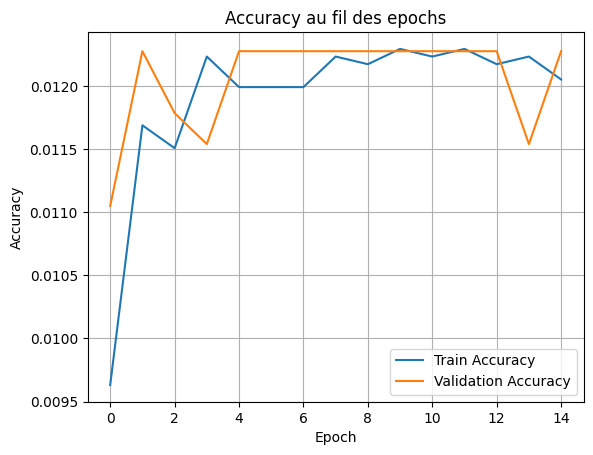

In [7]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy au fil des epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()